### Importing the Model

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
HUGGINGFACE_API_KEY = os.getenv("HUGGINGFACE_API_KEY")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGSMITH_PROJECT"] = LANGSMITH_PROJECT
os.environ["HUGGINGFACE_API_KEY"] = HUGGINGFACE_API_KEY
os.environ["SERPER_API_KEY"] = SERPER_API_KEY

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
from google import genai

llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", convert_system_message_to_human=True)

/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
llm.invoke("Hi do you think I am a good person?")

/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


AIMessage(content='That\'s a very deep and personal question. Thank you for asking it.\n\nAs an AI, I don\'t have personal feelings or the ability to know you. I can\'t see your actions, understand your intentions, or know what\'s in your heart. Because of that, I can\'t possibly make a judgment on something so personal and profound.\n\nHowever, I can offer a framework that many people find helpful when they think about this question. Perhaps you could ask yourself things like:\n\n*   **Intention:** Do you generally try to do the right thing and have a positive impact on others?\n*   **Empathy:** Do you try to understand and share the feelings of others?\n*   **Actions:** How do you treat people, especially those who can\'t do anything for you? Are your actions generally kind and considerate?\n*   **Growth:** When you make a mistake or hurt someone, do you acknowledge it, feel remorse, and try to do better next time?\n\nThe very fact that you\'re asking this question is, in my view, a 

In [5]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

### Creating the Retriever for RAG

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


### Creating the RAG Chain

In [7]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

print(f"---PROMPT--- {prompt}")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

---PROMPT--- input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


### Testing the RAG Chain

In [8]:
question = "tell me about agent memory."
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


In an LLM-powered autonomous agent, memory is divided into two main types: short-term and long-term. Short-term memory is considered in-context learning, limited by the finite context window of the model. Long-term memory provides the agent with the ability to retain and recall information over extended periods, often by using an external vector store for fast retrieval.


### Creating grade documents function

In [9]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class GradeDocuments(BaseModel):
    """ Returns a binary score according to the relevance of the documents with the question asked by the user. """

    binary_score: str = Field(
        description = "Are the documents relevant to the question, answer only in 'Yes' or 'No'."
    )

/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
# LLM with function call

structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """ 
    You are a Grader assessing the relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Finally, give a binary score 'Yes' or 'No' score to indicate whether the document is relevant to the question or not.
"""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved Document: \n \n {document} \n \n User Question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [11]:
question = "Tell me about Agent Memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

/var/folders/p_/v95prvpj4cz7y53gvmgm1d_r0000gn/T/ipykernel_48326/3447649127.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)
/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


binary_score='Yes'


In [12]:
question = "Tell me about Taj Mahal"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


binary_score='No'


In [13]:
from langchain_core.prompts import ChatPromptTemplate

system = """ 
    You are a question re-writer that converts an input question to a better version that is optimised for web search. 
    Look at the input and try to reason about the underlying semantic intent or meaning. 
"""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [14]:
question_rewriter.invoke({"question": question})

/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


'Here are a few improved versions of the question, each targeting a slightly different user intent:\n\n**Best Option (for a general overview):**\n\n> Key facts about the Taj Mahal\n\n**Why it\'s better:** This query is direct and asks for scannable, high-level information. Search engines are likely to return a knowledge panel, a "Top 10 facts" list, or a Wikipedia summary, which is what most users want when they ask a broad "tell me about" question.\n\n---\n**Other excellent alternatives:**\n\n*   **For a deeper dive into its story:**\n    > History of the Taj Mahal\n\n*   **For understanding its purpose:**\n    > Why was the Taj Mahal built?\n\n*   **For architectural details:**\n    > Taj Mahal architecture and construction'

### Creating required functions

In [15]:
def retrieve(state):
    """
    Retrieve the documents.

    Arguments:
        State(dict): The current graph state.

    Returns:

    """
    print("----RETRIEVE----")
    question = state['question']

    documents = retriever.get_relevant_documents(question)

    return {"documents": documents, "question": question}

In [16]:
def grade_documents(state):
    """ 
    Determines whether the retrieved documents are relevant to the question or not.

    Arguements:
        state(dict): The current graph state

    Returns:
        state(dict): Updates documents key with only filtered relevant documents
    """

    print("----Checking if the Document is Relevant to the Question or not----")

    question = state["question"]

    documents = state["documents"]

    filtered_docs = []

    web_search = "No"

    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )

        grade = score.binary_score

        if grade == "yes":
            print("----Grade: Document is Relevant----")
            filtered_docs.append(d)
        else:
            print("----Grade: Document is Not Relevant----")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

In [17]:
def generate(state):
    """
    Generate an answer relevant to the question asked by the user.

    Arguments: 
        state(dict): The current state of the graph.
    
    Returns:
        state(dict): New keys added to state, generation that contains LLM generation
    """

    print("----Generate----")

    question = state["question"]
    documents = state["documents"]

    generation = rag_chain.invoke({"context": documents, "question": question})

    return {"documents": documents, "question": question, "generation": generation}

In [18]:
def transform_query(state):
    """ 
    Transform the query to produce a better question in such a way that a web search is possible using that question.

    Arguements:
        state(dict): The current state of the graph

    Returns:
        state(dict): Updates the question key of the state with a transformed question which is suitable for web search.
    """

    print("----Transform the Query----")

    question = state["question"]

    documents = state["documents"]

    better_question = question_rewriter.invoke({"question", question})

    return {"documents": documents, "question": better_question}

### Web Crawling Using Tavily API

In [19]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults()

/var/folders/p_/v95prvpj4cz7y53gvmgm1d_r0000gn/T/ipykernel_48326/3433059501.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults()


In [20]:
from langchain.schema import Document

def web_search(state):
    """
    Web search based on transformed question. 

    Arguments: 
        state(dict): The current state of the graph

    Returns:
        state(dict): Updates the documents key with the results fetched from the web using the Tavily tool. 
    """

    print("----Web Search----")

    question = state["question"]

    documents = state["documents"]

    # Web search using Tavily

    docs = web_search_tool.invoke({"query": question})

    web_results = "\n".join(d["content"] for d in docs)

    web_results = Document(page_content = web_results)

    documents.append(web_results)

    return {"documents": documents, "question": question}

In [21]:
def decide_to_generate(state):
    """ 
    Determines whether to generate an answer or transform the query.

    Arguments: 
        state(dict): The current state of the graph.

    Returns: 
        str: binary decision for the next node to call (either "Yes" or "No")
    """
    print("----Asses the Graded Documents----")

    state["question"]

    web_search = state["web_search"]

    state["documents"]

    if web_search == "Yes":
        print("----Decision: All the documents are not relevant to the question, transform the query----")
        return "transform_query"
    else:
        print("----Decision: Generate----")
        return "generate"

### Creating a LangGraph Workflow

In [22]:
from langgraph.graph import StateGraph, END, START

In [23]:
from typing import List
from typing_extensions import TypedDict

class State(TypedDict):
    """
    Represents the State of our Graph.

    Attributes: 
        question: question
        generation: LLM generation
        web_search: whether to add web search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[Document]

In [24]:
workflow = StateGraph(State)

### Defining the nodes of LangGraph Graph

In [25]:
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search)

### Building the Graph

In [26]:
workflow.add_edge(START, "retrieve")

workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    }
)

workflow.add_edge("transform_query", "web_search_node")

workflow.add_edge("web_search_node", "generate")

workflow.add_edge("generate", END)

In [27]:
app = workflow.compile()

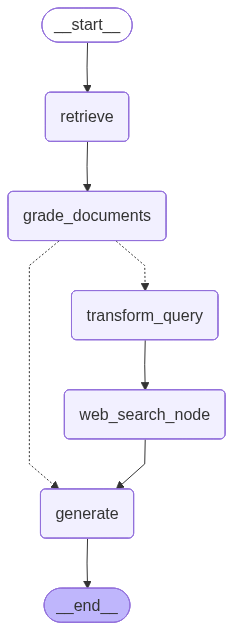

In [28]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [29]:
from pprint import pprint 

inputs = {"question": "Tell me about the Agent Memory"}

In [30]:
from pprint import pprint

inputs = {"question": "Tell me about the Agent Memory"}

for step in app.stream(inputs):
    for node, state in step.items():
        print(f"[{node}]")
        if "documents" in state:
            print(f"docs: {len(state['documents'])}")
        if "web_search" in state:
            print(f"web_search: {state['web_search']}")
        if "generation" in state:
            print("ANSWER:", state["generation"])
    print("-----")

# or just
final = app.invoke(inputs)
print("FINAL ANSWER:", final.get("generation"))


----RETRIEVE----
[retrieve]
docs: 4
-----
----Checking if the Document is Relevant to the Question or not----


/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


----Grade: Document is Not Relevant----


/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


----Grade: Document is Not Relevant----


/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


----Grade: Document is Not Relevant----


/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


----Grade: Document is Not Relevant----
----Asses the Graded Documents----
----Decision: All the documents are not relevant to the question, transform the query----
[grade_documents]
docs: 0
web_search: Yes
-----
----Transform the Query----


/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


[transform_query]
docs: 0
-----
----Web Search----
[web_search_node]
docs: 1
-----
----Generate----


/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


[generate]
docs: 1
ANSWER: In the context of AI agents, memory is the ability to retain and recall relevant information from past interactions or processed data. This allows an agent to maintain continuity and context over time, leading to more coherent and personalized responses. By using this stored information, the agent can learn, adapt, and improve its behavior for future tasks and interactions.
-----
----RETRIEVE----
----Checking if the Document is Relevant to the Question or not----


/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


----Grade: Document is Not Relevant----


/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


----Grade: Document is Not Relevant----


/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


----Grade: Document is Not Relevant----


/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


----Grade: Document is Not Relevant----
----Asses the Graded Documents----
----Decision: All the documents are not relevant to the question, transform the query----
----Transform the Query----


/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


----Web Search----
----Generate----


/Users/atharvabot7/Downloads/MLOPS-Tutorials/LangGraph/langgraph/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


KeyboardInterrupt: 